# Background

It is widely accepted that each of us has differing personality traits. One of the most established personality classification schemes is the **Myers-Briggs Type Indicator (MBTI)**, which breaks personality down into 4 major components:

1. Extroversion/Introversion
2. Sensing/Intuition
3. Thinking/Feeling
4. Judging/Perception

To assess MTBI, a questionnaire needs to be filled in by the interviewee. This is costly and time consuming, so **is there a faster, easier way of accurately assessing one's personality type?**

# The Problem

While meeting new people, I often try to guess their personality type and then ask them to take the test afterwards to see whether my prediction was right. Most of the time, I get one or two major categories right, which is not particularly impressive given that there are only two classes for each category. The probability of getting two classes right is 0.5^2 = 0.25, so I might as well just be lucky.

I thought I could do better and hence **in this project I will try to predict MTBI based on textual input**.

# Data

### Content
This dataset contains over 8600 rows of data, on each row is a person’s:

1. Type (This persons 4 letter MBTI code/type)
2. A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters))

### Acknowledgements
This data was collected through the PersonalityCafe forum, as it provides a large selection of people and their MBTI personality type, as well as what they have written.

# Exploratory data analysis and data cleaning

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import re
import seaborn as sns
import spacy
import keras
import tensorflow as tf
import ujson
import time
import os
import datetime

from sklearn import *
import sklearn

from xgboost import XGBClassifier
from collections import Counter
from tqdm import tqdm
from TwitteRNN.net import TwitteRNN

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  Depreca

In [2]:
mbti = pd.read_csv("data/mbti_1.csv")

In [3]:
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
mbti_descriptions = {"I": "Introversion", "E": "Extroversion",
                    "N": "Intuition", "S": "Sensing",
                    "T": "Thinking", "F": "Feeling",
                    "J": "Judging", "P": "Perceiving"}

types_list = list(mbti["type"])

# Map MBTI to int
type_to_int = {}
i = 0
for elem in types_list:
    if elem not in type_to_int:
        type_to_int[elem] = i
        i += 1

In [5]:
# Function to extract whether a person is an introvert or an extrovert
def get_major_type(value):
    if value.startswith("E"):
        return "E"
    else:
        return "I"

In [6]:
mbti["extrovert_introvert"] = mbti["type"].apply(lambda x: get_major_type(x))

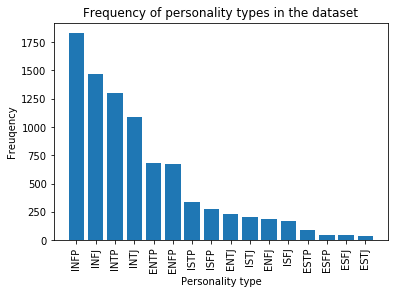

In [7]:
# Get frequency of each personality type
type_counts = Counter(types_list)
type_counts = sorted(type_counts.items(), key=lambda i: i[1], reverse=True)
type_sorted = []
count = []
for elem in type_counts:
    type_sorted.append(elem[0])
    count.append(elem[1])
pos = list(range(len(type_sorted)))
plt.bar(pos, count)
plt.xticks(pos, type_sorted, rotation="vertical")
plt.title("Frequency of personality types in the dataset")
plt.xlabel("Personality type")
plt.ylabel("Freuqency")
plt.show()

In [8]:
type_counts

[('INFP', 1832),
 ('INFJ', 1470),
 ('INTP', 1304),
 ('INTJ', 1091),
 ('ENTP', 685),
 ('ENFP', 675),
 ('ISTP', 337),
 ('ISFP', 271),
 ('ENTJ', 231),
 ('ISTJ', 205),
 ('ENFJ', 190),
 ('ISFJ', 166),
 ('ESTP', 89),
 ('ESFP', 48),
 ('ESFJ', 42),
 ('ESTJ', 39)]

In [9]:
print("Number of extroverts:", mbti["type"].str.startswith("E").sum())
print("Number of introverts:", mbti["type"].str.startswith("I").sum())

Number of extroverts: 1999
Number of introverts: 6676


Clearly, introvert personality types are the most common ones, making up for the top 4 personality types. **This also poses the issue of learning from unbalanced data**.

In [10]:
# Clean posts
def clean_post(post):
    post = post.lower()
    
    post = post.replace("|||", "")
    
    post = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', '', post, flags=re.MULTILINE) 
    
    punctuation = ['@','#','$','%','^','&','*','(',')','-','_','+','=','{','}','[',']','|','\\','"',"'",';',':','<','>','/']
    for punct in punctuation:
        post = post.replace(punct, '') 
    
    punctuation_common = [',','.','?','!','\n']
    for punct in punctuation_common:
        post = post.replace(punct, " ")
        
    post = re.sub("\s+", " ", post).strip()
    
    return post

posts_clean = [clean_post(post) for post in list(mbti["posts"])]
mbti["posts_clean"] = posts_clean

In [11]:
# Let's build a frequency distribution of words in posts
word_counts = Counter()
for post in posts_clean:
    word_counts.update(post.split(" "))

In [12]:
# Look at the number of words per comment for each individual poster
mbti["words_per_comment"] = mbti["posts_clean"].apply(lambda x: len(x.split())/50) # divide by 50 because data contains 50 latest comments for each poster

# Function to calculate standard deviation of number of words in each person's comments
def compute_comments_len_sd(comments):
    comments = comments.split("|||")
    comment_lengths = [len(x.split(" ")) for x in comments]
    return np.std(comment_lengths)

# Look at the standard deviation of numer of words per comment
mbti["wpc_sd"] = mbti["posts"].apply(lambda x: compute_comments_len_sd(x))

In [13]:
# Aggregate mean words per comment and standard deviation for introverts and extroverts
mbti.groupby("extrovert_introvert").mean()

,words_per_comment,wpc_sd
extrovert_introvert,,
E,25.207884,11.806299
I,25.128610,11.770911


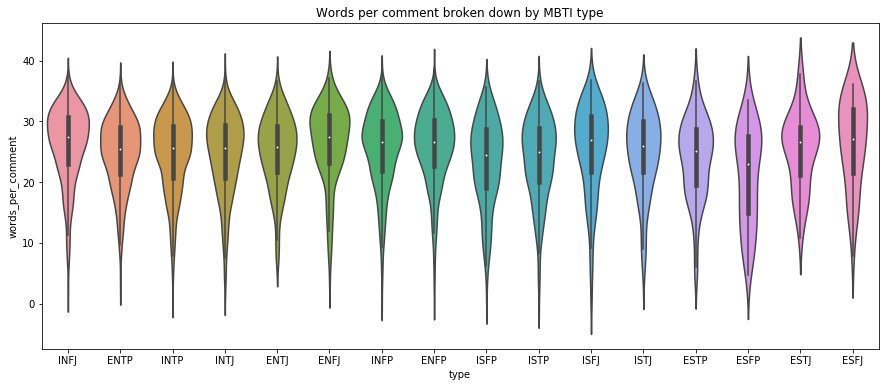

In [14]:
plt.figure(figsize=(15, 6))
sns.violinplot(x=mbti["type"], y=mbti["words_per_comment"])
plt.title("Words per comment broken down by MBTI type")
plt.show()

There are no significant differences in comment length for each MBTI type. However, one thing worth noting is that there is noticeably greater variability in lengths for ESFP compared to other types.

In [15]:
mbti.corr()

,words_per_comment,wpc_sd
words_per_comment,1.000000,-0.494264
wpc_sd,-0.494264,1.000000


Looking at a correlation table for variables in our dataset, we can see that there is a fairly strong negative correlation between the number of words per comment and the standard deviation of that number. This means that the longer one's comments are, the more they tend to be of similar length.

# How do different personalities "talk"?

In this section we will look at what parts of speech people with different MBTI types use and whether there are any interesting patterns.

In [16]:
# Get POS tags for given post
nlp = spacy.load("en_core_web_sm")
def count_pos(post, nlp):
    doc = nlp(post)
    pos_tag_counts = Counter([word.pos_ for word in doc])
    
    return pos_tag_counts

def count_pos_group(mbti_grouped, pers_type, nlp):
    all_pos_counts = Counter()
    mbti_grouped = mbti_grouped.get_group(pers_type)
    for post in tqdm(mbti_grouped["posts"]):
        all_pos_counts += count_pos(clean_post(post), nlp)
    
    return all_pos_counts

In [17]:
# Group MBTI df by personality type
mbti_grouped = mbti.groupby("type")

In [18]:
# This takes really long due to large computational requirements of spaCy's POS tagger
#pos_dict = {}
#i = 1
#for pers_type in set(mbti["type"]):
#    print("Processing type {}/16".format(i))
#    pos_dict[pers_type] = count_pos_group(mbti_grouped, pers_type, nlp)
#    i += 1

# Let's load the pre-computed file instead
with open("data/pos_by_mbti.json", "r") as f:
    pos_dict = ujson.load(f)

We will only look into adjectives, nouns and verbs to simplify the analysis a bit.

In [19]:
def create_proportion_df(pos_dict, pers_type):
    pos_dict = pos_dict[pers_type]
    adj = pos_dict["ADJ"]
    noun = pos_dict["NOUN"]
    verb = pos_dict["VERB"]
    total = adj + noun + verb
    adj_prop = adj / total
    noun_prop = noun / total
    verb_prop = verb / total
    vals = [adj_prop, noun_prop, verb_prop]
    
    return pd.DataFrame.from_dict({"type": pers_type, "value": vals, "pos": ["ADJ", "NOUN", "VERB"]})

In [20]:
# Create and fill a DF with proportions of POS tags used
prop_df = create_proportion_df(pos_dict, "ENFJ")
for pers_type in set(mbti["type"]):
    prop_df = prop_df.append(create_proportion_df(pos_dict, pers_type), ignore_index=True)
prop_df = prop_df.drop_duplicates()
assert len(prop_df) == 16*3

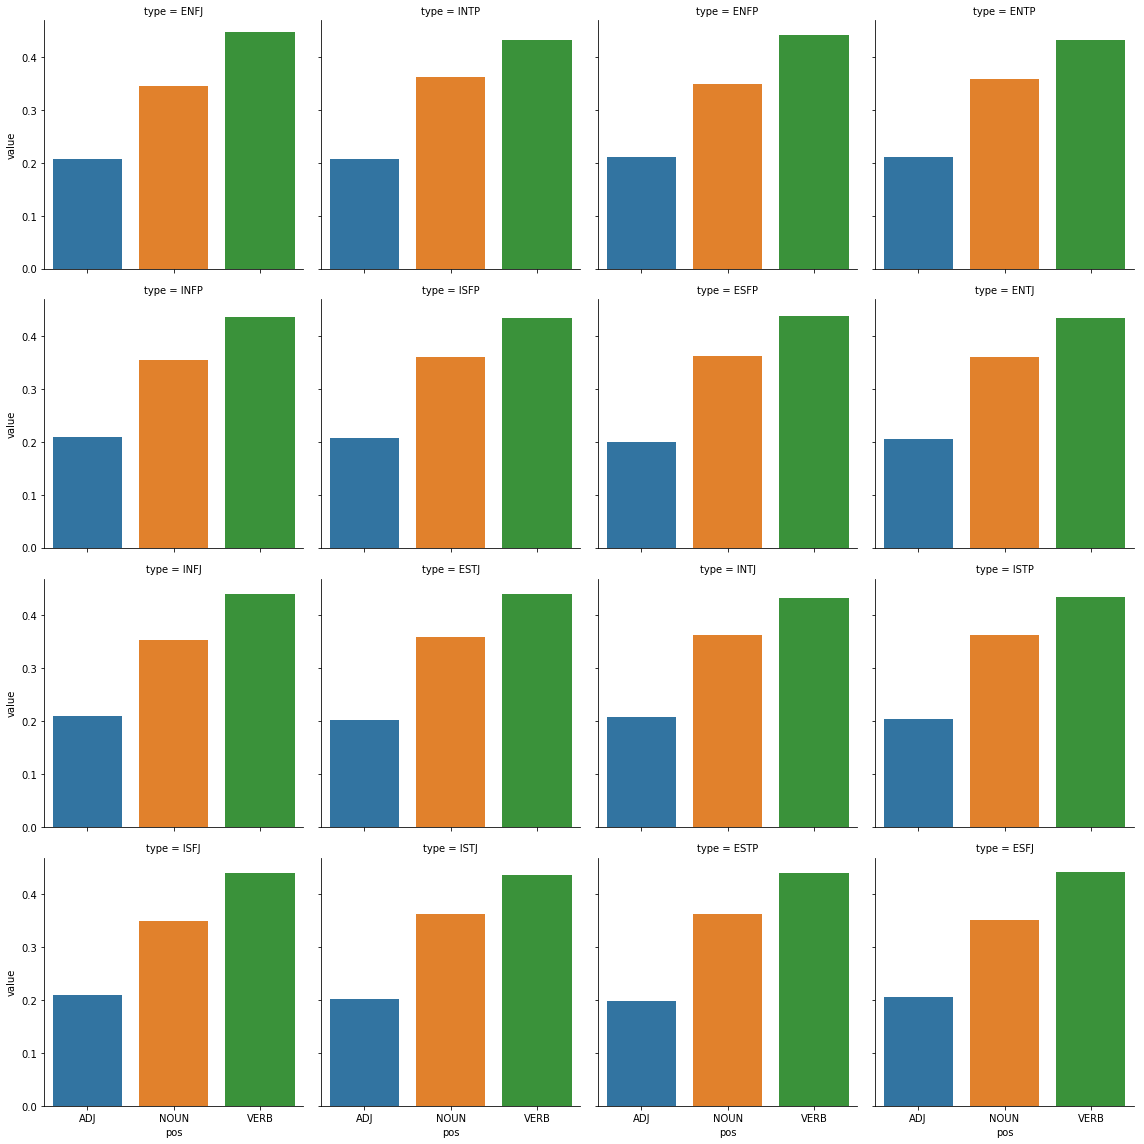

In [21]:
sns.factorplot(x="pos", y="value", col="type", data=prop_df, kind="bar", col_wrap=4)
plt.show()

There are virtually no differences in the proportions of adjectives, nouns and verbs used by people with different personality types. Let's aggregate the results and look at the introvert/extrovert level.

In [22]:
prop_df["extrovert_introvert"] = prop_df["type"].apply(lambda x: get_major_type(x))

In [23]:
prop_df.groupby(["extrovert_introvert", "pos"]).mean()

value
extrovert_introvert pos           
E                   ADJ   0.204983
                    NOUN  0.355791
                    VERB  0.439226
I                   ADJ   0.206906
                    NOUN  0.358037
                    VERB  0.435057

Whether one is an introvert or an extrovert doesn't seem to influence the peoportions of analysed parts of speech used either.

## Sentiment analysis of MBTI personality types

An interesting question one might ask is: are certain personality types (e.g. extrovert vs introvert) more likely to lead to comments which exhibit high degree of positivity or negativity? To answer that, we will perform **sentiment analysis using a CNN-LSTM network trained on Twitter sentiment data**. This is a word-level model.

The network has already been pre-trained on data I collected, so the only thing to do is inference on the posts data.

In [24]:
model = TwitteRNN(vocab_size=100000, max_seq_len=100)
model.create_model()
model.load_model(weights_path="./TwitteRNN/model_checkpoints/weights-improvement-02-0.823.hdf5",
                 dict_filename="./TwitteRNN/model_dict.pickle")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           1600000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 32)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,654,869
Trainable params: 1,654,869
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Make predictions
preds = []
for post in tqdm(posts_clean):
    preds.append(model.predict(post))
mbti["sentiment"] = preds

100%|██████████| 8675/8675 [01:26<00:00, 100.59it/s]


In [26]:
# Calculate mean sentiment scores by MBTI category
sent_df = pd.DataFrame.from_dict({"type": list(mbti["type"]), "sentiment": preds})
sent_df.groupby("type").mean()

,sentiment
type,
ENFJ,0.393118
ENFP,0.403136
ENTJ,0.415464
ENTP,0.396118
ESFJ,0.464341
ESFP,0.485437
ESTJ,0.363824
ESTP,0.349136
INFJ,0.390710


In [27]:
# Get sentiment values for extroverts and introverts
ptype = sent_df["type"]
extrovert_sentiment = np.array(sent_df[ptype.str.startswith("E")]["sentiment"])
introvert_sentiment = np.array(sent_df[ptype.str.startswith("I")]["sentiment"])
print("Mean extrovert sentiment:", extrovert_sentiment.mean())
print("Mean introvert sentiment:", introvert_sentiment.mean())

Mean extrovert sentiment: 0.401294482971
Mean introvert sentiment: 0.383199256169


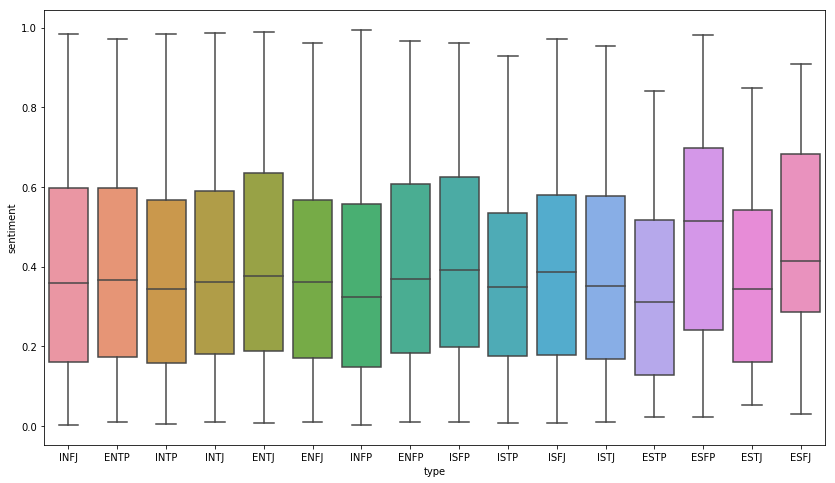

In [28]:
plt.figure(figsize=(14, 8))
sns.boxplot(x=sent_df["type"], y=sent_df["sentiment"])
plt.show()

The sentiment for extroverts seems to be slightly higher than for introverts on average. However, due to very unbalanced data, it would be unreasonable to draw any solid conclusions from that analysis.

It is interesting to note that **the highest sentiment was observed for the ESFP type**, which agrees well with the fact that it is commonly known as "The Entertainer" (see: https://www.16personalities.com/esfp-personality).

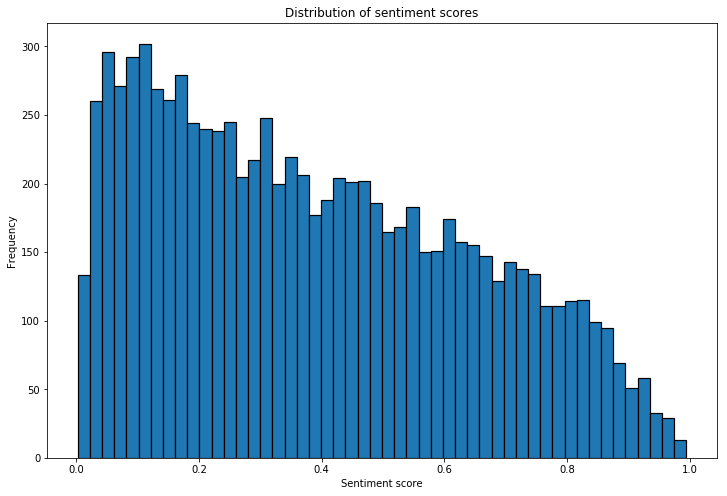

In [29]:
# Plot frequency distribution of sentiment scores
plt.figure(figsize=(12, 8))
plt.hist(preds, bins=50, edgecolor="black", linewidth=1.2)
plt.xlabel("Sentiment score")
plt.ylabel("Frequency")
plt.title("Distribution of sentiment scores")
plt.show()

Interestingly, the model tends to be biased towards assigning lower sentiment scores, which is evident from the non-uniform distribution. This could be due to the fact that it was trained on a significantly different dataset which contains mostly very short messages (Twitter). Therefore, these results should be taken with a pinch of salt.

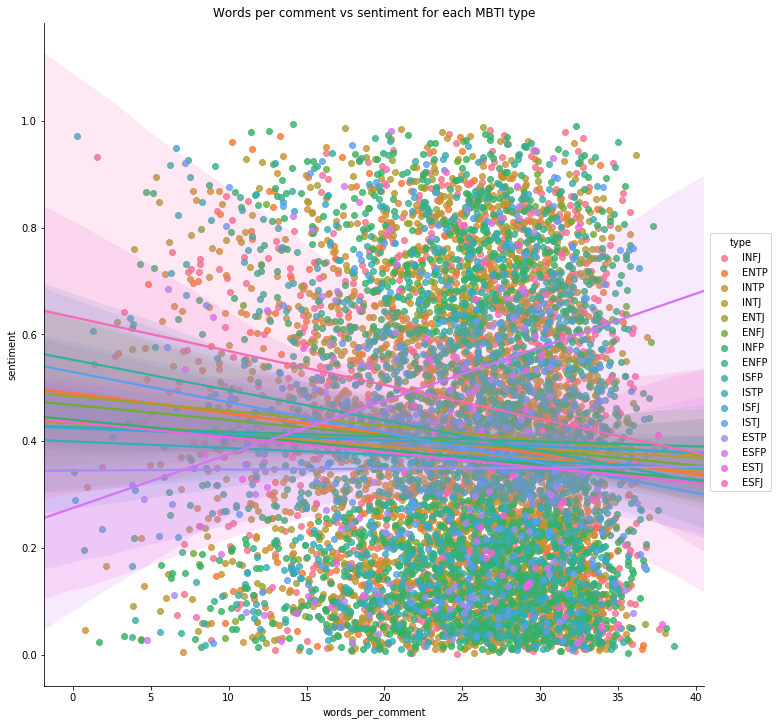

In [30]:
sns.lmplot(x="words_per_comment", y="sentiment", data=mbti, hue="type", fit_reg=True, size=10)
plt.title("Words per comment vs sentiment for each MBTI type")
plt.show()

In [31]:
mbti["words_per_comment"].corr(mbti["sentiment"])

-0.066350360203453904

There is a slightly negative correlation between number of words per comment and sentiment, indicating that long posts are more likely to be more negative. What is particularly worht noting is that **the only personality type for which this correlation is positive is ESTP ("The Entrepreneur")**. Seems like the longer a startup founder's pitch, the better! However, hold on just yet with dismissing the concept of an elevator pitch ;)

# Predicting MBTI type

A natural question to ask is: is it possible to predict one's personality based on his writing style? In this section, we will attempt to do just that using several different approaches.

## XGBoost with TF-IDF features

For now, let's try a non-Deep Learning approach and use the XGBoost model supplied with TF-IDF scores. The reason for using truncated Singular Value Decomposition is the prohibitively long training time for the original TF-IDF vector dimensionality. The number of components was picked by experimentation.

In [32]:
# Split data intro train/test
X_train, X_test, y_train, y_test = model_selection.train_test_split(posts_clean, mbti["type"], test_size=0.2, random_state=42)

In [33]:
# Define and train XGBoost
xgb = XGBClassifier(max_depth=10, learning_rate=0.2, n_estimators=100, objective="multi:softmax")
tfidf = feature_extraction.text.TfidfVectorizer(ngram_range=(1, 1), stop_words='english')
tsvd = decomposition.TruncatedSVD(n_components=100) # this is needed due to prohibitively long training time otherwise
model = pipeline.Pipeline([('tfidf', tfidf), ('tsvd', tsvd), ('xgb', xgb)])
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

In [34]:
# Predict and check mean accuracy
xgb_preds = model.predict(X_test)
np.mean(xgb_preds == np.asarray(y_test))

0.64149855907780984

64% mean accuracy, definitely an improvement over the random guessing 6.25%. Let's look more closely at model predictions now to see what went wrong.

In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  7   2   0   1   0   0   0   0  11  14   2   3   0   0   1   0]
 [  1  74   0   8   0   0   0   0  11  17   8   3   0   0   1   2]
 [  1   2  24   3   0   0   0   0   4   3   4   3   0   0   0   0]
 [  0   5   2  77   0   0   0   0  15  11   8  15   0   0   1   1]
 [  0   0   0   1   2   0   0   0   2   1   0   0   0   0   1   0]
 [  0   2   2   1   0   0   0   0   0   2   0   0   0   1   0   0]
 [  0   0   1   1   0   0   0   0   1   3   0   1   0   0   0   0]
 [  0   1   0   1   0   0   0   2   2   0   1   2   0   0   0   6]
 [  1   2   4   8   0   0   0   0 192  46  16  15   0   1   2   1]
 [  4   7   1   7   1   0   0   0  29 290  15  11   0   3   0   2]
 [  0   3   2   6   1   0   0   0  17  18 134  10   0   1   1   0]
 [  0   1   2   9   0   0   0   0  14  31  13 218   0   0   2   3]
 [  0   1   1   1   0   0   0   0   5   9   3   3  19   1   1   1]
 [  1   1   0   2   0   0   0   0   2  17   5   1   0  19   1   4]
 [  0   3   0   0   0 

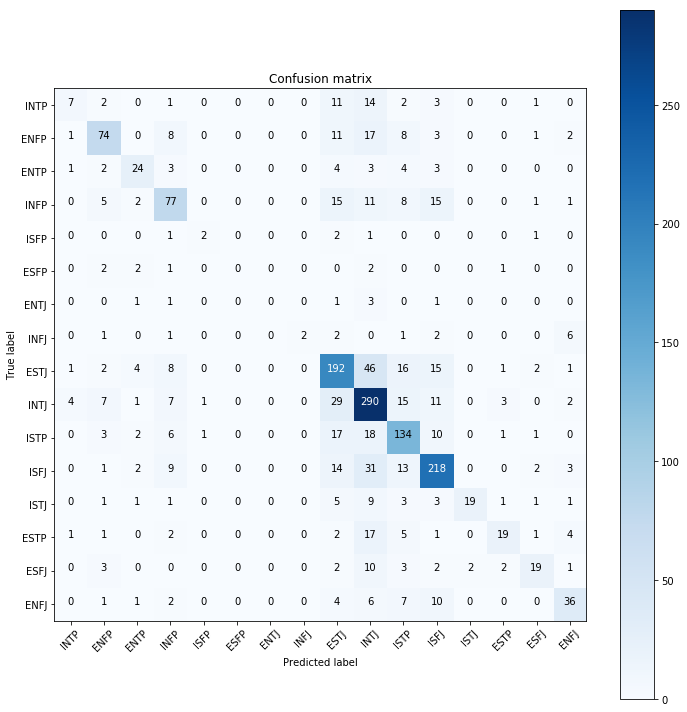

In [36]:
cnf_matrix = metrics.confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=list(set(mbti["type"])), normalize=False)
plt.show()

We can see that the model does fairly well overall. It seems to make the most mistakes when distinguishing between e.g. ISFP & INFP, ISTP & INFP or ENFP & INFP. This makes sense intuitively, since these personality pairs differ by only one trait, which most likely does not lead to a much more distincive writing style. This makes it harder for the model to distinguish between them.

The accuracy is much better than the one obtained by random guessing (1/16). However, it is possible we could do better using a **Recurrent Neural Network**, treating comments as sequences of words or characters. Simple TF-IDF features are not able to capture long-term dependencies present in natural language, while RNNs are well suited for that task, so the hope is that the model will perform better.

## Recurrent Neural Network with word-level features

First, let's build a dictionary of words from all posts

In [37]:
# Retain words which cumulatively make up for 90% of the vocabulary (to keep vocabulary size small)
word_freqs = np.array(sorted(list(word_counts.values()), reverse=True))
thresh_freq = np.percentile(word_freqs, 0)
thresh_word_idx = len(word_freqs[word_freqs >= thresh_freq])

Now, create mapping from word to integer index and the corresponding reverse mapping.

In [38]:
# Create and sort vocabulary
vocab = sorted(word_counts, key=word_counts.get, reverse=True)[0:thresh_word_idx]
word2int = {word: index for index, word in enumerate(vocab)}
int2word = {v: k for k, v in word2int.items()}

# Add UNK label
#int2word[len(int2word)+1] = "UNK"
#word2int["UNK"] = len(int2word)+1

Using the mappings created above, encode the posts to sequences of integers.

In [39]:
# Encode posts
def encode_post(post, word2int, unk_label="UNK"):
    post_encoded = []
    post_split = post.split(" ")
    for word in post_split:
        try:
            post_encoded.append(word2int[word])
        except KeyError:
            post_encoded.append(word2int[unk_label])
    return post_encoded

posts_encoded = []
for post in posts_clean:
    posts_encoded.append(encode_post(post, word2int))

Check the maximum and minimum sequence lengths. This is needed to constrain the input sequences to constant length.

In [40]:
# See how long the posts are
max_len = 0
min_len = 999999
for post in posts_encoded:
    current_len = len(post)
    if current_len > max_len:
        max_len = current_len
    if min_len > current_len:
        min_len = current_len
print("Maximum post length: {}".format(max_len))
print("Minimum post length: {}".format(min_len))

Maximum post length: 1931
Minimum post length: 4


Seems like a sequence length of 500 might not be too bad. Let's try that.
In addition, we will transform the output variable to one-hot-encoded format and split the data into train/test sets.

In [41]:
# Pick a sequence length and zero-pad posts shorter than that
def one_hot(label, dim):
    vec = np.zeros((dim, 1))
    vec[label] = 1
    return vec.transpose()[0]

seq_len = 500

X2 = keras.preprocessing.sequence.pad_sequences(posts_encoded, maxlen=seq_len, 
                                           padding="post", truncating="post")
y2 = [one_hot(type_to_int[pers_type], len(set(mbti["type"]))) for pers_type in mbti["type"]]

X_train2, X_test2, y_train2, y_test2 = sklearn.model_selection.train_test_split(X2, y2, test_size=0.1, random_state=42)

Here, we define the RNN used for prediction. Instead of using bare integer representations of words, we will use the Embedding layer to learn word embeddings. To avoid overfitting, we use dropout.

In [57]:
tf.reset_default_graph()

lstm_size = 256
lstm_layers = 1
batch_size = 256
learning_rate = 0.01
embed_dim=250

n_words = len(word2int) + 1

X = tf.placeholder(tf.int32, [None, None], name="X")
y = tf.placeholder(tf.int32, [None, None], name="y")

keep_prob = tf.placeholder(tf.float32, name="keep_prob")

embedding = tf.Variable(tf.random_uniform(shape=(n_words, embed_dim), minval=-1, maxval=1))
embed_lookup = tf.nn.embedding_lookup(embedding, X)

# Define cell factory
lstm = tf.contrib.rnn.GRUCell(lstm_size)

# Apply dropout
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

# Stack multiple cells
cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)

# Get initial cell state (all zeros)
initial_state = cell.zero_state(batch_size, tf.float32)

# Get outputs and states of cells
outputs, states = tf.nn.dynamic_rnn(cell, embed_lookup, dtype=tf.float32)

# Apply dense layer
dense = tf.layers.dense(outputs[:, -1], 16, activation=tf.nn.relu)
dense_preds = tf.layers.dense(dense, 16, activation=tf.nn.softmax)

# Define cost and optimizer
cost = tf.losses.mean_squared_error(y, dense_preds)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

correct_preds = tf.equal(tf.cast(tf.round(dense_preds), tf.int32), y)
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

In [58]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

Let's train the model and see how it performs!

In [114]:
epochs = 3

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x_batch, y_batch) in enumerate(get_batches(X_train2, y_train2, batch_size), 1):
            feed = {X: x_batch,
                    y: y_batch,
                    keep_prob: 0.7,
                    initial_state: state}
            loss, state, _, acc = sess.run([cost, states, optimizer, accuracy], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss),
                      "Accuracy: {:.3f}".format(acc))

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x_batch, y_batch in get_batches(X_test2, y_test2, batch_size):
                    feed = {X: x_batch,
                            y: y_batch,
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, states], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1
    saver.save(sess, "checkpoints/mbti.ckpt")

Epoch: 1/3 Iteration: 5 Train loss: 0.058 Accuracy: 0.938
Epoch: 1/3 Iteration: 10 Train loss: 0.055 Accuracy: 0.938
Epoch: 1/3 Iteration: 15 Train loss: 0.055 Accuracy: 0.938
Epoch: 1/3 Iteration: 20 Train loss: 0.054 Accuracy: 0.938
Epoch: 1/3 Iteration: 25 Train loss: 0.055 Accuracy: 0.938
Val acc: 0.938
Epoch: 1/3 Iteration: 30 Train loss: 0.055 Accuracy: 0.938
Epoch: 2/3 Iteration: 35 Train loss: 0.054 Accuracy: 0.938
Epoch: 2/3 Iteration: 40 Train loss: 0.053 Accuracy: 0.938
Epoch: 2/3 Iteration: 45 Train loss: 0.053 Accuracy: 0.938
Epoch: 2/3 Iteration: 50 Train loss: 0.052 Accuracy: 0.938
Val acc: 0.938
Epoch: 2/3 Iteration: 55 Train loss: 0.053 Accuracy: 0.938
Epoch: 2/3 Iteration: 60 Train loss: 0.052 Accuracy: 0.939
Epoch: 3/3 Iteration: 65 Train loss: 0.050 Accuracy: 0.940
Epoch: 3/3 Iteration: 70 Train loss: 0.046 Accuracy: 0.942
Epoch: 3/3 Iteration: 75 Train loss: 0.044 Accuracy: 0.945
Val acc: 0.936
Epoch: 3/3 Iteration: 80 Train loss: 0.042 Accuracy: 0.949
Epoch: 3/3 I

Clearly, the RNN outperforms the TF-IDF based XGBoost model, achieving 94% accuracy with just 3 epochs.

# Summary

This project has briefly explored the concept of personality prediction. The main takeaways for me are: 

1. Proper preprocessing of textual data is crucial for achieving good performance of predictive models.
2. While a TF-IDF approach is very simple, it doesn't provide high enough accuracy to be used in any serious application on this specific task.
3. A Recurrent Neural Network, while taking much more time to train, provides excellent accuracy. With additional tweaks such as implementing attention or adding more layers it is likely that the accuracy would go up even higher. 